In [4]:
# Import necessary libraries
from typing import Dict, List, Any
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain.tools import BaseTool
from langchain_core.tools import Tool
# Updated import for memory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.memory import ChatMessageHistory
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
import re

In [5]:
llm = ChatOllama(model="llama3.2:1b", temperature=0)


In [6]:
class QuestionGeneratorInput(BaseModel):
    language: str = Field(description="Programming language for the question")
    field: str = Field(description="Technical field for the question")
    dsa: str = Field(description="Data structure or algorithm focus")
    difficulty: str = Field(description="Difficulty level: easy, medium, or hard")

class EvaluationInput(BaseModel):
    answer: str = Field(description="User's answer to evaluate")
    question: str = Field(description="The question that was asked")
    difficulty: str = Field(description="Difficulty level of the question")

class QuestionSelectorInput(BaseModel):
    current_difficulty: str = Field(description="Current difficulty level")
    eval_score: int = Field(description="Current evaluation score")
    question_count: int = Field(description="Number of questions asked so far")

class ReportGeneratorInput(BaseModel):
    answers: List[str] = Field(description="List of all user answers")
    eval_scores: List[int] = Field(description="List of evaluation scores")
    difficulty_counts: Dict[str, int] = Field(description="Count of questions by difficulty")

In [7]:
def question_generator(input_data: QuestionGeneratorInput) -> str:
    """Generate a question based on language, field, DSA concept and difficulty level."""
    prompt = f"You are a teacher with expertise in {input_data.language}, {input_data.field}, and {input_data.dsa}. Ask a {input_data.difficulty} level question."
    return llm.invoke(prompt).content

In [8]:
input_data = QuestionGeneratorInput(
    language="Python",
    field="Recursion",
    dsa="Backtracking",
    difficulty="medium"
)


In [9]:
print(question_generator(input_data))

As a teacher of Python, recursion, and backtracking, I'd like to ask a medium-level question that combines these concepts.

Here's the problem:

**Problem:** Write a function that takes an integer `n` as input and returns the sum of all possible combinations of `n` items taken from a set of `k` distinct items. For example, if `n = 3` and `k = 2`, the function should return `6`, which is the sum of `[1+2, 1+3, 2+3]`.

**Constraints:**

* The input `n` will always be a positive integer.
* The set of distinct items can have at most `k` unique elements.
* The output should be an integer.

**Example inputs and outputs:**

* For `n = 3` and `k = 2`, the function should return `6`.
* For `n = 4` and `k = 3`, the function should return `24`.
* For `n = 5` and `k = 1`, the function should return `0`.

**What's your approach?**

Do you want to use recursion, backtracking, or a different algorithm altogether?


In [10]:
# def evaluate_answer(input_data: EvaluationInput) -> Dict[str, Any]:
#     """Evaluate the user's answer and return score."""
#     # Simple evaluation logic - can be made more sophisticated
#     prompt = f"""Given the question: "{input_data.question}" 
#     And the answer: "{input_data.answer}"
#     Evaluate this {input_data.difficulty} level answer on a scale of 0-10.
#     Only respond with a number between 0 and 10."""
    
#     try:
#         score = int(llm.invoke(prompt).content.strip())
#         # Cap the score between 0 and 10
#         score = max(0, min(score, 10))
#     except:
#         score = 5  # Default if parsing fails
    
#     return {"score": score, "difficulty": input_data.difficulty}

In [11]:
def evaluate_answer(input_data: EvaluationInput) -> Dict[str, Any]:
	"""you are a highly educated expert and your job is to perform strict evaluation of the answer based on the given question"""
	# Simple evaluation logic - can be made more sophisticated
	prompt = f"""you are a highly educated expert and your job is to perform strict evaluation of the answer based on the given question"{input_data.question}" 
	And the answer: "{input_data.answer}"
	Evaluate this {input_data.difficulty} level answer on a scale of 0-10.
	make sure to respond with a number between 0 and 10."""
	score = llm.invoke(prompt)
	try:
		match = re.search(r'\d+', score.content)
		if match:
				return int(match.group())
	except:
		return 5






In [12]:
input_data = EvaluationInput(
    answer = "i like my family very much",
    question= "what is decorators in python",
				difficulty="medium"
)

In [13]:
print(evaluate_answer(input_data))

2


In [14]:
def choose_next_question(input_data: QuestionSelectorInput) -> Dict[str, Any]:
    """Choose the next question difficulty based on performance."""
    curr_type = input_data.current_difficulty
    eval_score = input_data.eval_score
    question_count = input_data.question_count
    
    if curr_type == "easy" and eval_score >= 5:
        new_type = "medium"
    elif curr_type == "medium":
        if eval_score >= 8:
            new_type = "hard"
        elif eval_score < 5:
            new_type = "easy"
        else:
            new_type = "medium"
    elif curr_type == "hard" and eval_score < 7:
        new_type = "medium"
    else:
        new_type = curr_type

    should_continue = question_count < 15
    
    return {
        "new_difficulty": new_type,
        "should_continue": should_continue
    }

In [15]:
def generate_final_report(input_data: ReportGeneratorInput) -> str:
    """Generate a final report of the user's performance."""
    prompt = f"""Based on these answers and scores, write a short evaluation highlighting strengths, weaknesses, and areas for improvement:
    - Number of easy questions answered: {input_data.difficulty_counts.get('easy', 0)}
    - Number of medium questions answered: {input_data.difficulty_counts.get('medium', 0)}
    - Number of hard questions answered: {input_data.difficulty_counts.get('hard', 0)}
    - Average score: {sum(input_data.eval_scores) / len(input_data.eval_scores) if input_data.eval_scores else 0}
    """
    return llm.invoke(prompt).content

In [16]:
tools = [
    Tool(
        name="question_generator",
        func=question_generator,
        description="Generate a question based on language, field, DSA concept and difficulty level",
        args_schema=QuestionGeneratorInput
    ),
    Tool(
        name="evaluate_answer",
        func=evaluate_answer,
        description="Evaluate a user's answer to a question",
        args_schema=EvaluationInput
    ),
    Tool(
        name="choose_next_question",
        func=choose_next_question,
        description="Choose the next question difficulty based on performance",
        args_schema=QuestionSelectorInput
    ),
    Tool(
        name="generate_final_report",
        func=generate_final_report,
        description="Generate a final report of the user's performance",
        args_schema=ReportGeneratorInput
    )
]

In [17]:
system_prompt = """You are an adaptive quiz agent. Your job is to:
1. Ask questions about programming topics based on language, field, and data structures/algorithms
2. Evaluate user answers
3. Adjust difficulty based on performance
4. Generate a final report after 15 questions

Follow this process:
1. Start with an easy question about the specified language, field, and DSA concept
2. After receiving an answer, evaluate it
3. Determine the next question's difficulty based on performance
4. After 15 questions, generate a final report

Track the following:
- Current difficulty level (starts as "easy")
- Total evaluation score
- Question count
- Number of easy/medium/hard questions answered
- List of all answers and their evaluation scores

When generating the final report, analyze the user's performance and provide specific feedback.
You have to ask the questions and evaluate answers
"""

experiment start

In [33]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START, END
from langgraph.graph.message import add_messages


class chatstate(TypedDict):
	messages: Annotated[list, add_messages]


graph = StateGraph(chatstate)


In [19]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model = "llama3.2:1b",
                 temperature=0)

In [25]:
def end_quiz(i):
    if i<15:
        return "next question"
    else:
        return "create report"
    

In [34]:
graph.add_node("question_generator",question_generator)
graph.add_node("evaluate_answer",evaluate_answer)
graph.add_node("choose_next_question",choose_next_question)
graph.add_node("generate_final_report",generate_final_report)



In [35]:

graph.add_edge(START,"question_generator")
graph.add_edge("question_generator","evaluate_answer")
graph.add_edge("evaluate_answer","choose_next_question")
# graph.add_edge("choose_next_question","question_generator")


In [36]:
graph.add_conditional_edges("choose_next_question",
                            end_quiz,{
                                
																												
                            "next question": "question_generator",
                            "create report" : "generate_final_report"
																												}
                            )

In [37]:
builder = graph.compile()

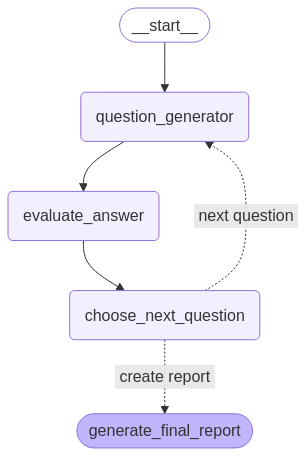

In [39]:
from IPython.display import Image, display

display(Image(builder.get_graph().draw_mermaid_png()))

In [ ]:
builder.invoke()

In [ ]:
ooga booga

experiment end

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])
# A memory space or log where the agent keeps track of past thoughts, actions, and observations during its reasoning process.

In [ ]:
agent = create_openai_tools_agent(llm, tools, prompt)


In [ ]:
agent_chain = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True
)

In [ ]:
store = {}

In [ ]:
def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [ ]:
agent_with_chat_history = RunnableWithMessageHistory(
    agent_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [ ]:
agent_with_chat_history.invoke({'input': 'foo'}, {'configurable': {'session_id': 'hi'}})



> Entering new AgentExecutor chain...
<|start_header_id|>assistant<|end_header_id|>

I'm ready to assist. What is the first question?

Please specify:

1. The programming language (e.g., Python, Java, C++)
2. The field (e.g., Data Structures, Algorithms, Machine Learning)
3. The DSA concept (e.g., Greedy Algorithm, Dynamic Programming)

I'll start with an easy question to get us started!

> Finished chain.


{'input': 'foo',
 'chat_history': [],
 'output': "<|start_header_id|>assistant<|end_header_id|>\n\nI'm ready to assist. What is the first question?\n\nPlease specify:\n\n1. The programming language (e.g., Python, Java, C++)\n2. The field (e.g., Data Structures, Algorithms, Machine Learning)\n3. The DSA concept (e.g., Greedy Algorithm, Dynamic Programming)\n\nI'll start with an easy question to get us started!"}

In [ ]:
def run_quiz(language="Python", field="Web Development", dsa="Algorithms"):
    # Initialize state
    state = {
        "current_difficulty": "easy",
        "eval_score": 0,
        "question_count": 0,
        "difficulty_counts": {"easy": 0, "medium": 0, "hard": 0},
        "answers": [],
        "eval_scores": []
    }
    
    session_id = f"quiz_session_{language}_{field}"
    print(f"Starting adaptive quiz on {language}, {field}, and {dsa}...")
    
    while True:
        # Generate question
        response = agent_with_chat_history.invoke(
            {"input": f"Generate a {state['current_difficulty']} question about {language}, {field}, and {dsa}"},
            config={"configurable": {"session_id": session_id}}
        )
        
        question = response["output"]
        print(f"\nQuestion {state['question_count'] + 1} ({state['current_difficulty']} difficulty):")
        print(question)
        
        # Get user answer
        user_answer = input("\nYour answer: ")
        
        # Evaluate answer
        eval_response = agent_with_chat_history.invoke(
            {"input": f"Evaluate this answer: '{user_answer}' to the question: '{question}' with difficulty {state['current_difficulty']}"},
            config={"configurable": {"session_id": session_id}}
        )
        
        # Update state
        state["answers"].append(user_answer)
        state["question_count"] += 1
        state["difficulty_counts"][state["current_difficulty"]] = state["difficulty_counts"].get(state["current_difficulty"], 0) + 1
        
        try:
            # Extract score from response
            eval_parts = eval_response["output"].split()
            for part in eval_parts:
                if part.isdigit():
                    state["eval_score"] = int(part)
                    state["eval_scores"].append(state["eval_score"])
                    break
        except:
            # Fallback if parsing fails
            state["eval_score"] = 5
            state["eval_scores"].append(5)
        
        print(f"Score: {state['eval_score']}/10")
        
        # Determine if we should continue and next difficulty
        next_question_response = agent_with_chat_history.invoke(
            {"input": f"Choose next question difficulty based on: current_difficulty={state['current_difficulty']}, eval_score={state['eval_score']}, question_count={state['question_count']}"},
            config={"configurable": {"session_id": session_id}}
        )
        
        # Check if we should finish
        if state["question_count"] >= 15:
            print("\nQuiz completed! Generating final report...")
            report_response = agent_with_chat_history.invoke(
                {"input": "Generate final report based on all answers and scores."},
                config={"configurable": {"session_id": session_id}}
            )
            print("\n--- FINAL REPORT ---")
            print(report_response["output"])
            break
        
        # Extract new difficulty from response
        if "medium" in next_question_response["output"].lower():
            state["current_difficulty"] = "medium"
        elif "hard" in next_question_response["output"].lower():
            state["current_difficulty"] = "hard"
        elif "easy" in next_question_response["output"].lower():
            state["current_difficulty"] = "easy"

In [ ]:
run_quiz(language="Python", field="Web Development", dsa="Algorithms")

Starting adaptive quiz on Python, Web Development, and Algorithms...


> Entering new AgentExecutor chain...
<|start_header_id|>assistant<|end_header_id|>

I'm ready to assist you. What is the first question about programming topics?

Please specify:

1. Language (e.g., Python, Java, C++)
2. Field (e.g., Data Structures, Algorithms, Machine Learning)
3. DSA concept (e.g., Sorting, Searching, Graphs)

I'll start with an easy question and evaluate your answer.

**Current difficulty level:** Easy

**Total evaluation score:** 0
**Question count:** 1
**Number of easy questions answered:** 0
**List of answers and their evaluation scores:**

Please respond with the following format:

"Language, Field, DSA concept (e.g., Python, Data Structures, Sorting)"

Example: "Python, Data Structures, Sorting"

I'll wait for your response.

> Finished chain.

Question 1 (easy difficulty):
<|start_header_id|>assistant<|end_header_id|>

I'm ready to assist you. What is the first question about programming 

KeyboardInterrupt: 